
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [3]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20
N_STEPS = 1 if SMOKE_TEST else 30

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {}}


In [4]:
generator = MOBOGenerator(vocs=tnk_vocs, reference_point = {"y1":1.5,"y2":1.5})
generator.n_monte_carlo_samples = N_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS

X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0]}))

for i in range(N_STEPS):
    print(i)
    X.step()

optim=OptimOptions(num_restarts=1, raw_samples=50, sequential=True, use_nearby_initial_points=True, max_travel_distances=None) acq=MOBOAcqOptions(proximal_lengthscales=[1.0, 1.0], use_transformed_proximal_weights=True, monte_carlo_samples=128, reference_point={'y1': 1.5, 'y2': 1.5}) model=ModelOptions(function=<function create_standard_model at 0x00000198D148ACA0>, kwargs=kwargs(use_conservative_prior_lengthscale=False, use_conservative_prior_mean=False, use_low_noise_prior=True)) n_initial=(2,)
0


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1811: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


1


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


2


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


3


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


4


C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\botorch\optim\optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Because you specified `batch_initial_conditions`, optimization will not be retried with new initial conditions and will proceed with the current solution. Suggested remediation: Try again with different `batch_initial_conditions`, or don't provide `batch_initial_conditions.`
  warnings.warn(first_warn_msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [5]:
X.generator.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000020,False,NaN
2,0.750000,1.000000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000007,False,NaN
3,0.428720,2.007932,0.428720,2.007932,3.313092,2.278940,"[1, 2, 3]",0.000023,False,dummy_constant
4,0.134244,0.387830,0.134244,0.387830,-0.889617,0.146360,"[1, 2, 3]",0.000023,False,dummy_constant
5,0.442316,0.924067,0.442316,0.924067,-0.015720,0.183160,"[1, 2, 3]",0.000022,False,dummy_constant
6,0.461993,0.935771,0.461993,0.935771,0.039728,0.191341,"[1, 2, 3]",0.000020,False,dummy_constant
7,0.874432,0.477673,0.874432,0.477673,0.007310,0.140698,"[1, 2, 3]",0.000023,False,dummy_constant
8,1.062458,0.216807,1.062458,0.216807,0.275509,0.396557,"[1, 2, 3]",0.000019,False,dummy_constant
9,0.928535,0.000880,0.928535,0.000880,-0.237810,0.432763,"[1, 2, 3]",0.000023,False,dummy_constant
10,0.725610,0.732733,0.725610,0.732733,-0.036287,0.105065,"[1, 2, 3]",0.000018,False,dummy_constant


## plot results


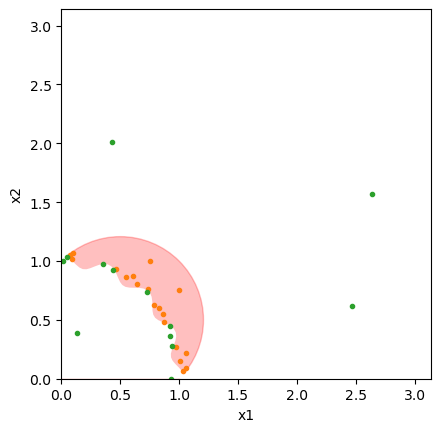

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)


ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

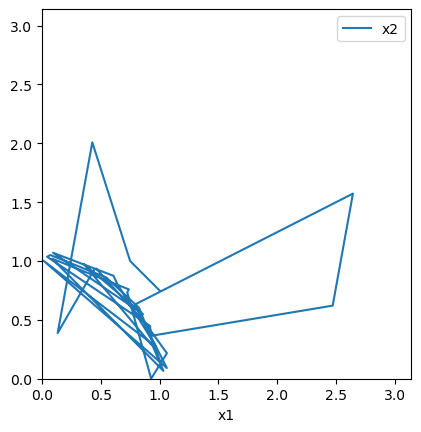

In [7]:
ax = history.plot("x1", "x2")
ax.set_ylim(0, 3.14)
ax.set_xlim(0, 3.14)
ax.set_aspect("equal")

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[0.24501697 0.99184235]]


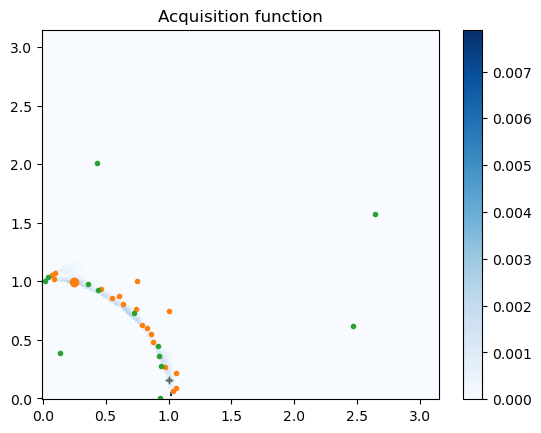

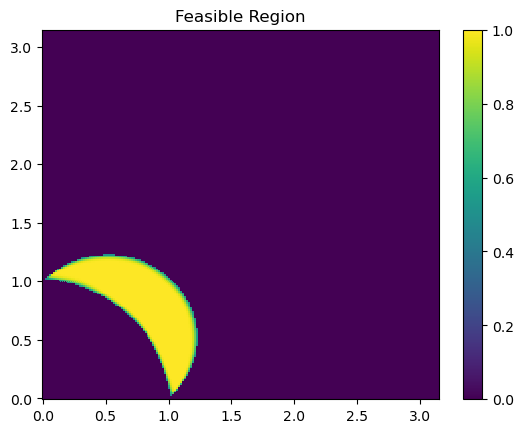

In [8]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

xx, yy = xx.numpy(), yy.numpy()

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = pd.DataFrame(X.generator.generate(1), index=[0])
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
%%time
candidate = X.generator.generate(1)

CPU times: total: 12 s
Wall time: 1.5 s
